In [1]:
import os
import numpy as np
import rasterio
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

ModuleNotFoundError: No module named 'numpy'

In [125]:
# Normalization function
def normalize_data(images):
    for i in range(images.shape[1]):  # For each band
        band = images[:, i, :, :]
        min_val = np.min(band)
        max_val = np.max(band)
        images[:, i, :, :] = (band - min_val) / (max_val - min_val)
    return images

# Data loading function
def load_data(images_dir, labels_dir):
    images = []
    labels = []
    for i in tqdm(range(306), desc="Loading data"):
        img_path = os.path.join(images_dir, f"{i}.tif")
        label_path = os.path.join(labels_dir, f"{i}.png")
        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)
        label = np.array(Image.open(label_path)).astype(np.float32)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load and normalize data
images_dir = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\images"
labels_dir = r"C:\Users\Lenovo\OneDrive - Alexandria University\Desktop\Projects\Water Segmentation\data-20240829T123932Z-001\data\labels"

X, y = load_data(images_dir, labels_dir)
X_normalized = normalize_data(X)

Loading data:   0%|                                                                            | 0/306 [00:00<?, ?it/s]C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Loading data: 100%|█████████████████████████████████████████████████████████████████| 306/306 [00:02<00:00, 139.58it/s]


In [127]:
# Split the data
X_trainval, X_test, y_trainval, y_test = train_test_split(X_normalized, y, test_size=0.10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Data shapes:
X_train: (233, 12, 128, 128)
y_train: (233, 128, 128)
X_val: (42, 12, 128, 128)
y_val: (42, 128, 128)
X_test: (31, 12, 128, 128)
y_test: (31, 128, 128)


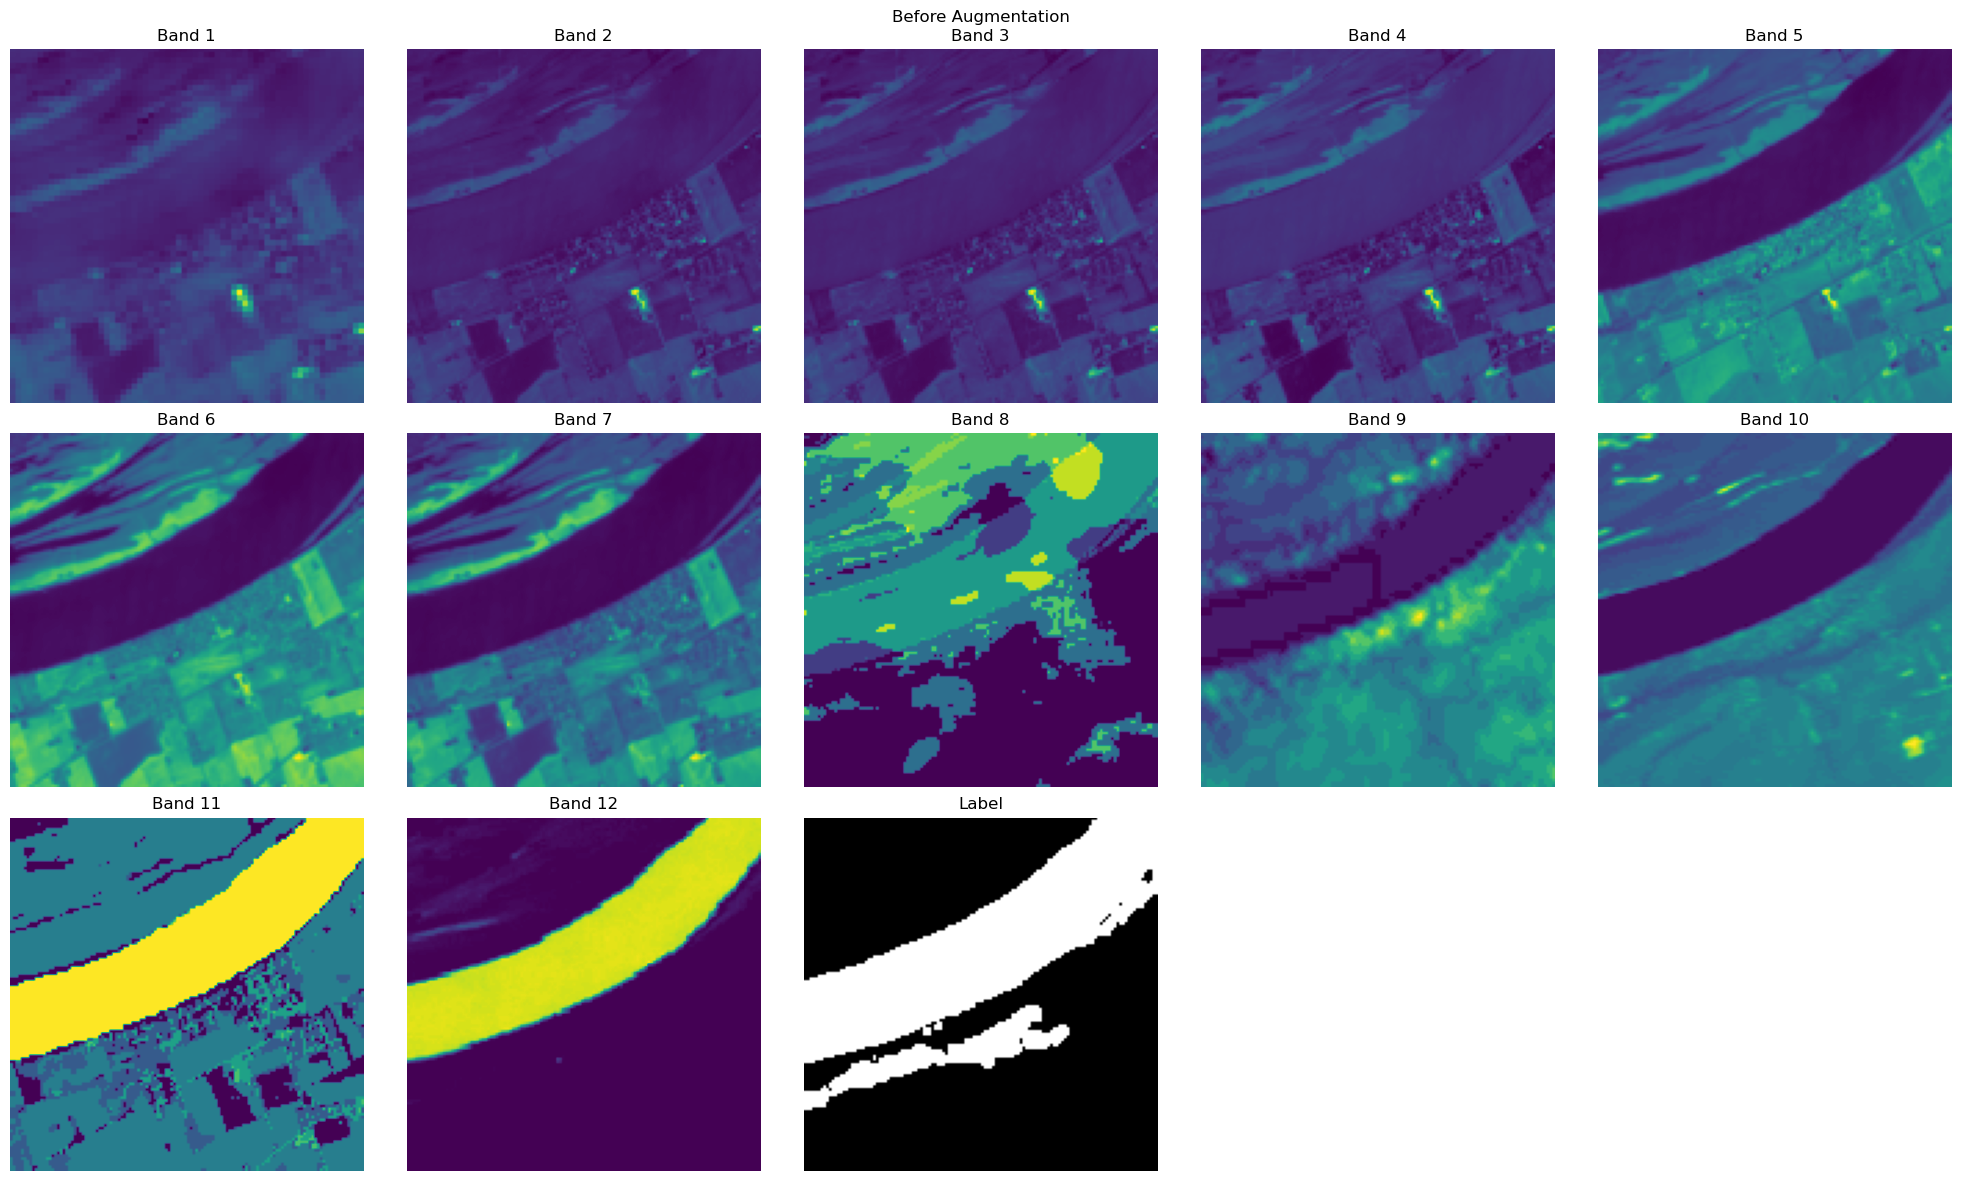

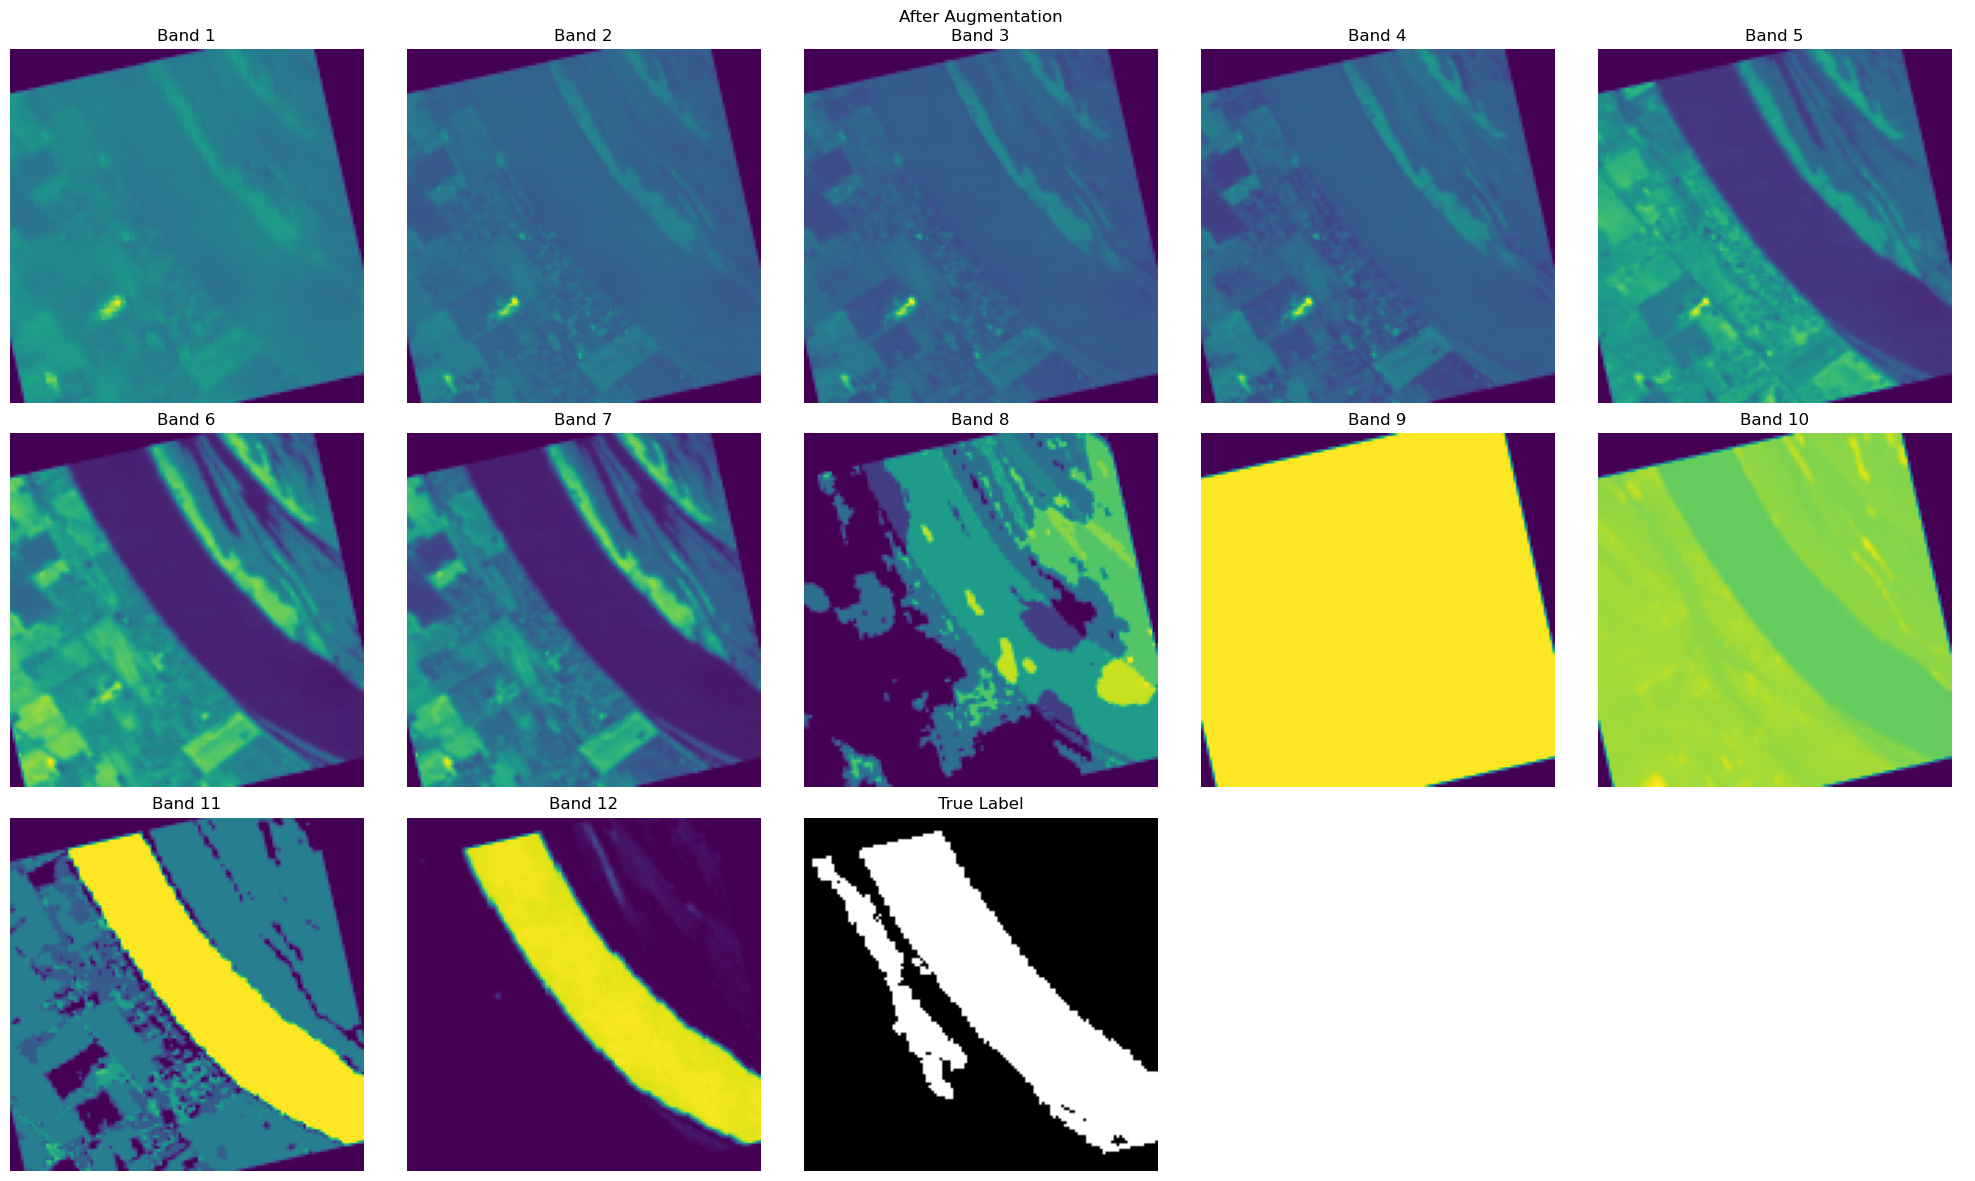

In [129]:
# Visualization function for augmented image with all 12 bands and true label
def visualize_augmented_image(image, label, title="Augmented Image"):
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    
    # Display all 12 bands
    for i, ax in enumerate(axes.flat):
        if i < 12:  # Ensure it stays within the 12 bands
            ax.imshow(image[i], cmap='viridis')
            ax.set_title(f'Band {i+1}')
        elif i == 12:
            ax.imshow(label, cmap='gray')
            ax.set_title('True Label')
        ax.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize before and after augmentation with all 12 bands and true label
def visualize_before_after_augmentation(image, label):
    # Before augmentation
    visualize_normalized_image(image, label, title="Before Augmentation")
    
    # Apply augmentation
    augmented = get_augmentation()(image=image.transpose(1, 2, 0), mask=label)
    aug_image = augmented['image']
    aug_label = augmented['mask']
    
    # After augmentation with all 12 bands and true label
    visualize_augmented_image(aug_image, aug_label, title="After Augmentation")

# Example usage
visualize_before_after_augmentation(X_train[15], y_train[15])

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet  # Install via pip: pip install efficientnet-pytorch

class EnhancedASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedASPP, self).__init__()
        dilations = [1, 6, 12, 18, 24]
        self.aspp_blocks = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation, bias=False)
            for dilation in dilations
        ])
        self.conv1x1 = nn.Conv2d(out_channels * len(dilations), out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = torch.cat([aspp(x) for aspp in self.aspp_blocks], dim=1)
        x = self.conv1x1(x)
        x = self.bn(x)
        return self.relu(x)

class DeepLabv3PlusEfficientNet(nn.Module):
    def __init__(self, num_classes=1, in_channels=12, backbone='efficientnet-b7'):
        super(DeepLabv3PlusEfficientNet, self).__init__()
        # Using EfficientNet as the backbone
        self.backbone = EfficientNet.from_pretrained(backbone, in_channels=in_channels)
        
        # ASPP module with output channels = 256
        self.aspp = EnhancedASPP(in_channels=320, out_channels=256)
        self.conv1 = nn.Conv2d(256, 256, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        
        # Low-level feature adjustment for concatenation
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        # Extract features from EfficientNet backbone
        x = self.backbone.extract_features(x)
        
        # Apply ASPP
        x = self.aspp(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)
        x = self.dropout(x)

        # Process low-level features and concatenate with ASPP outputs
        low_level_feat = F.interpolate(x, scale_factor=0.5, mode='bilinear', align_corners=True)
        x = torch.cat((x, low_level_feat), dim=1)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # Final convolution
        x = self.conv3(x)
        x = F.interpolate(x, scale_factor=4, mode='bilinear', align_corners=True)

        return x

# Initialize the updated model with EfficientNet
model = DeepLabv3PlusEfficientNet(num_classes=1, in_channels=12)

ModuleNotFoundError: No module named 'efficientnet_pytorch'

In [146]:
class WaterSegmentationDataset(Dataset):
    def __init__(self, images, masks, augment=False):
        self.images = images
        self.masks = masks
        self.augment = augment
        self.transform = get_augmentation() if augment else None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.augment:
            augmented = self.transform(image=image.transpose(1, 2, 0), mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)
        else:
            image = torch.from_numpy(image).float()
            mask = torch.from_numpy(mask).float().unsqueeze(0)

        return image, mask

# Set up datasets and dataloaders
train_dataset = WaterSegmentationDataset(X_train, y_train, augment=False)
val_dataset = WaterSegmentationDataset(X_val, y_val)
test_dataset = WaterSegmentationDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [147]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # Prevents nans when loss is zero
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(CombinedLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha, gamma)
        self.dice_loss = DiceLoss()

    def forward(self, preds, targets):
        focal = self.focal_loss(preds, targets)
        dice = self.dice_loss(preds, targets)
        return focal + dice

def calculate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            predicted = (outputs > 0.5).float()
            correct += (predicted == masks).sum().item()
            total += masks.numel()
    return correct / total

def iou_score(preds, targets):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.bool()
    targets = targets.bool()
    intersection = (preds & targets).float().sum((1, 2))
    union = (preds | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

# Initialize model, loss, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLabv3Plus(num_classes=1, in_channels=12).to(device)
criterion = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)  # AdamW for better weight decay handling
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

In [148]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_accuracy = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou += iou_score(outputs, masks)
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_accuracy += (preds == masks).float().mean().item()

    val_loss /= num_batches
    val_iou /= num_batches
    val_accuracy /= num_batches

    return val_loss, val_iou, val_accuracy

# Modified training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_val_iou = 0.0
    train_losses, val_losses = [], []
    train_ious, val_ious = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        train_accuracy = 0.0
        num_batches = len(train_loader)

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_iou += iou_score(outputs, masks)
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_accuracy += (preds == masks).float().mean().item()

        train_loss /= num_batches
        train_iou /= num_batches
        train_accuracy /= num_batches

        val_loss, val_iou, val_accuracy = validate_model(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_ious.append(train_iou)
        val_ious.append(val_iou)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies

In [149]:
# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    accuracy = np.mean(all_preds == all_targets)
    iou = iou_score(torch.from_numpy(all_preds), torch.from_numpy(all_targets))
    precision = precision_score(all_targets.flatten(), all_preds.flatten())
    recall = recall_score(all_targets.flatten(), all_preds.flatten())
    f1 = f1_score(all_targets.flatten(), all_preds.flatten())

    return accuracy, iou, precision, recall, f1

In [152]:
# Visualization function for metrics
def plot_metrics(train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(epochs, train_ious, 'b-', label='Training IoU')
    plt.plot(epochs, val_ious, 'r-', label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.subplot(133)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to visualize predictions
def visualize_predictions(model, test_dataset, num_samples=5):
    model.eval()
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    for idx in indices:
        image, mask = test_dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image)
            pred = torch.sigmoid(output) > 0.5
        
        image = image.squeeze().cpu().numpy()
        mask = mask.squeeze().cpu().numpy()
        pred = pred.squeeze().cpu().numpy()
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(np.transpose(image[:3], (1, 2, 0)))  # Display first 3 bands as RGB
        axes[0].set_title('Input Image (First 3 bands)')
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('True Mask')
        axes[2].imshow(pred, cmap='gray')
        axes[2].set_title('Predicted Mask')
        
        for ax in axes:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

In [153]:
model = model.to(device)
# Training the model
num_epochs = 100
train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
)

Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.65it/s]


Epoch 1/100
Train Loss: 0.0317, Train IoU: 0.4605, Train Accuracy: 0.7934
Val Loss: 0.0740, Val IoU: 0.2968, Val Accuracy: 0.6647


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.75it/s]


Epoch 2/100
Train Loss: 0.0232, Train IoU: 0.5685, Train Accuracy: 0.8614
Val Loss: 0.0182, Val IoU: 0.6649, Val Accuracy: 0.8728


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.54it/s]


Epoch 3/100
Train Loss: 0.0199, Train IoU: 0.6278, Train Accuracy: 0.8862
Val Loss: 0.0158, Val IoU: 0.7282, Val Accuracy: 0.8993


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.28it/s]


Epoch 4/100
Train Loss: 0.0187, Train IoU: 0.6207, Train Accuracy: 0.8855
Val Loss: 0.0140, Val IoU: 0.7342, Val Accuracy: 0.9034


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.28it/s]


Epoch 5/100
Train Loss: 0.0159, Train IoU: 0.6582, Train Accuracy: 0.9018
Val Loss: 0.0130, Val IoU: 0.7390, Val Accuracy: 0.9098


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.02it/s]


Epoch 6/100
Train Loss: 0.0157, Train IoU: 0.6501, Train Accuracy: 0.9031
Val Loss: 0.0124, Val IoU: 0.7526, Val Accuracy: 0.9156


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.91it/s]


Epoch 7/100
Train Loss: 0.0145, Train IoU: 0.6615, Train Accuracy: 0.9114
Val Loss: 0.0119, Val IoU: 0.7642, Val Accuracy: 0.9246


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.01it/s]


Epoch 8/100
Train Loss: 0.0140, Train IoU: 0.6741, Train Accuracy: 0.9129
Val Loss: 0.0120, Val IoU: 0.7733, Val Accuracy: 0.9273


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.91it/s]


Epoch 9/100
Train Loss: 0.0140, Train IoU: 0.6791, Train Accuracy: 0.9117
Val Loss: 0.0121, Val IoU: 0.7590, Val Accuracy: 0.9242


Epoch 10/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.94it/s]


Epoch 10/100
Train Loss: 0.0143, Train IoU: 0.6886, Train Accuracy: 0.9108
Val Loss: 0.0155, Val IoU: 0.7617, Val Accuracy: 0.9169


Epoch 11/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]


Epoch 11/100
Train Loss: 0.0142, Train IoU: 0.6848, Train Accuracy: 0.9148
Val Loss: 0.0143, Val IoU: 0.7763, Val Accuracy: 0.9114


Epoch 12/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.07it/s]


Epoch 12/100
Train Loss: 0.0140, Train IoU: 0.6887, Train Accuracy: 0.9109
Val Loss: 0.0116, Val IoU: 0.7715, Val Accuracy: 0.9290


Epoch 13/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.93it/s]


Epoch 13/100
Train Loss: 0.0147, Train IoU: 0.6984, Train Accuracy: 0.9119
Val Loss: 0.0135, Val IoU: 0.7528, Val Accuracy: 0.9213


Epoch 14/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.61it/s]


Epoch 14/100
Train Loss: 0.0131, Train IoU: 0.7057, Train Accuracy: 0.9183
Val Loss: 0.0121, Val IoU: 0.7835, Val Accuracy: 0.9312


Epoch 15/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.84it/s]


Epoch 15/100
Train Loss: 0.0176, Train IoU: 0.6974, Train Accuracy: 0.8972
Val Loss: 0.0161, Val IoU: 0.7104, Val Accuracy: 0.9041


Epoch 16/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.73it/s]


Epoch 16/100
Train Loss: 0.0131, Train IoU: 0.7035, Train Accuracy: 0.9176
Val Loss: 0.0148, Val IoU: 0.7308, Val Accuracy: 0.9068


Epoch 17/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.50it/s]


Epoch 17/100
Train Loss: 0.0128, Train IoU: 0.7149, Train Accuracy: 0.9197
Val Loss: 0.0112, Val IoU: 0.7849, Val Accuracy: 0.9299


Epoch 18/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.89it/s]


Epoch 18/100
Train Loss: 0.0118, Train IoU: 0.7144, Train Accuracy: 0.9282
Val Loss: 0.0117, Val IoU: 0.7702, Val Accuracy: 0.9280


Epoch 19/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.25it/s]


Epoch 19/100
Train Loss: 0.0113, Train IoU: 0.7273, Train Accuracy: 0.9290
Val Loss: 0.0119, Val IoU: 0.7668, Val Accuracy: 0.9198


Epoch 20/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 20/100
Train Loss: 0.0118, Train IoU: 0.7044, Train Accuracy: 0.9250
Val Loss: 0.0116, Val IoU: 0.7897, Val Accuracy: 0.9315


Epoch 21/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.86it/s]


Epoch 21/100
Train Loss: 0.0113, Train IoU: 0.7225, Train Accuracy: 0.9267
Val Loss: 0.0120, Val IoU: 0.7833, Val Accuracy: 0.9257


Epoch 22/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.01it/s]


Epoch 22/100
Train Loss: 0.0119, Train IoU: 0.7341, Train Accuracy: 0.9288
Val Loss: 0.0114, Val IoU: 0.7822, Val Accuracy: 0.9266


Epoch 23/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]


Epoch 23/100
Train Loss: 0.0121, Train IoU: 0.7349, Train Accuracy: 0.9262
Val Loss: 0.0119, Val IoU: 0.7792, Val Accuracy: 0.9240


Epoch 24/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch 24/100
Train Loss: 0.0101, Train IoU: 0.7515, Train Accuracy: 0.9384
Val Loss: 0.0126, Val IoU: 0.7718, Val Accuracy: 0.9196


Epoch 25/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.51it/s]


Epoch 25/100
Train Loss: 0.0129, Train IoU: 0.7450, Train Accuracy: 0.9267
Val Loss: 0.0123, Val IoU: 0.7749, Val Accuracy: 0.9272


Epoch 26/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]


Epoch 26/100
Train Loss: 0.0128, Train IoU: 0.7360, Train Accuracy: 0.9242
Val Loss: 0.0115, Val IoU: 0.7909, Val Accuracy: 0.9298


Epoch 27/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]


Epoch 27/100
Train Loss: 0.0159, Train IoU: 0.7345, Train Accuracy: 0.9139
Val Loss: 0.0110, Val IoU: 0.7816, Val Accuracy: 0.9313


Epoch 28/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]


Epoch 28/100
Train Loss: 0.0118, Train IoU: 0.7287, Train Accuracy: 0.9293
Val Loss: 0.0122, Val IoU: 0.7779, Val Accuracy: 0.9291


Epoch 29/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.35it/s]


Epoch 29/100
Train Loss: 0.0103, Train IoU: 0.7404, Train Accuracy: 0.9331
Val Loss: 0.0117, Val IoU: 0.7800, Val Accuracy: 0.9282


Epoch 30/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch 30/100
Train Loss: 0.0100, Train IoU: 0.7328, Train Accuracy: 0.9375
Val Loss: 0.0108, Val IoU: 0.7849, Val Accuracy: 0.9306


Epoch 31/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.39it/s]


Epoch 31/100
Train Loss: 0.0100, Train IoU: 0.7383, Train Accuracy: 0.9376
Val Loss: 0.0117, Val IoU: 0.7832, Val Accuracy: 0.9299


Epoch 32/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.61it/s]


Epoch 32/100
Train Loss: 0.0094, Train IoU: 0.7447, Train Accuracy: 0.9408
Val Loss: 0.0109, Val IoU: 0.7888, Val Accuracy: 0.9286


Epoch 33/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 33/100
Train Loss: 0.0150, Train IoU: 0.7395, Train Accuracy: 0.9136
Val Loss: 0.0122, Val IoU: 0.7698, Val Accuracy: 0.9292


Epoch 34/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]


Epoch 34/100
Train Loss: 0.0119, Train IoU: 0.7465, Train Accuracy: 0.9314
Val Loss: 0.0110, Val IoU: 0.7894, Val Accuracy: 0.9321


Epoch 35/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch 35/100
Train Loss: 0.0108, Train IoU: 0.7272, Train Accuracy: 0.9325
Val Loss: 0.0119, Val IoU: 0.7764, Val Accuracy: 0.9283


Epoch 36/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.19it/s]


Epoch 36/100
Train Loss: 0.0093, Train IoU: 0.7606, Train Accuracy: 0.9411
Val Loss: 0.0110, Val IoU: 0.7868, Val Accuracy: 0.9329


Epoch 37/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.93it/s]


Epoch 37/100
Train Loss: 0.0105, Train IoU: 0.7497, Train Accuracy: 0.9287
Val Loss: 0.0111, Val IoU: 0.7891, Val Accuracy: 0.9307


Epoch 38/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]


Epoch 38/100
Train Loss: 0.0092, Train IoU: 0.7582, Train Accuracy: 0.9409
Val Loss: 0.0110, Val IoU: 0.7869, Val Accuracy: 0.9321


Epoch 39/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]


Epoch 39/100
Train Loss: 0.0091, Train IoU: 0.7609, Train Accuracy: 0.9415
Val Loss: 0.0110, Val IoU: 0.7877, Val Accuracy: 0.9325


Epoch 40/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.35it/s]


Epoch 40/100
Train Loss: 0.0103, Train IoU: 0.7591, Train Accuracy: 0.9382
Val Loss: 0.0110, Val IoU: 0.7888, Val Accuracy: 0.9330


Epoch 41/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.11it/s]


Epoch 41/100
Train Loss: 0.0094, Train IoU: 0.7637, Train Accuracy: 0.9400
Val Loss: 0.0112, Val IoU: 0.7860, Val Accuracy: 0.9327


Epoch 42/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Epoch 42/100
Train Loss: 0.0103, Train IoU: 0.7585, Train Accuracy: 0.9365
Val Loss: 0.0109, Val IoU: 0.7912, Val Accuracy: 0.9352


Epoch 43/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.74it/s]


Epoch 43/100
Train Loss: 0.0086, Train IoU: 0.7583, Train Accuracy: 0.9447
Val Loss: 0.0110, Val IoU: 0.7928, Val Accuracy: 0.9343


Epoch 44/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.67it/s]


Epoch 44/100
Train Loss: 0.0096, Train IoU: 0.7489, Train Accuracy: 0.9406
Val Loss: 0.0112, Val IoU: 0.7851, Val Accuracy: 0.9331


Epoch 45/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.76it/s]


Epoch 45/100
Train Loss: 0.0087, Train IoU: 0.7531, Train Accuracy: 0.9444
Val Loss: 0.0114, Val IoU: 0.7884, Val Accuracy: 0.9329


Epoch 46/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 46/100
Train Loss: 0.0091, Train IoU: 0.7593, Train Accuracy: 0.9417
Val Loss: 0.0111, Val IoU: 0.7901, Val Accuracy: 0.9343


Epoch 47/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.14it/s]


Epoch 47/100
Train Loss: 0.0113, Train IoU: 0.7609, Train Accuracy: 0.9336
Val Loss: 0.0114, Val IoU: 0.7848, Val Accuracy: 0.9330


Epoch 48/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.81it/s]


Epoch 48/100
Train Loss: 0.0093, Train IoU: 0.7555, Train Accuracy: 0.9411
Val Loss: 0.0106, Val IoU: 0.7854, Val Accuracy: 0.9274


Epoch 49/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.49it/s]


Epoch 49/100
Train Loss: 0.0102, Train IoU: 0.7554, Train Accuracy: 0.9329
Val Loss: 0.0104, Val IoU: 0.7804, Val Accuracy: 0.9292


Epoch 50/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.59it/s]


Epoch 50/100
Train Loss: 0.0091, Train IoU: 0.7648, Train Accuracy: 0.9425
Val Loss: 0.0100, Val IoU: 0.7868, Val Accuracy: 0.9324


Epoch 51/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]


Epoch 51/100
Train Loss: 0.0087, Train IoU: 0.7702, Train Accuracy: 0.9448
Val Loss: 0.0103, Val IoU: 0.7865, Val Accuracy: 0.9305


Epoch 52/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch 52/100
Train Loss: 0.0086, Train IoU: 0.7743, Train Accuracy: 0.9449
Val Loss: 0.0099, Val IoU: 0.7907, Val Accuracy: 0.9339


Epoch 53/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.06it/s]


Epoch 53/100
Train Loss: 0.0092, Train IoU: 0.7681, Train Accuracy: 0.9369
Val Loss: 0.0110, Val IoU: 0.7871, Val Accuracy: 0.9323


Epoch 54/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.15it/s]


Epoch 54/100
Train Loss: 0.0102, Train IoU: 0.7545, Train Accuracy: 0.9342
Val Loss: 0.0103, Val IoU: 0.7903, Val Accuracy: 0.9346


Epoch 55/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.88it/s]


Epoch 55/100
Train Loss: 0.0095, Train IoU: 0.7566, Train Accuracy: 0.9378
Val Loss: 0.0110, Val IoU: 0.7853, Val Accuracy: 0.9319


Epoch 56/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.49it/s]


Epoch 56/100
Train Loss: 0.0090, Train IoU: 0.7634, Train Accuracy: 0.9420
Val Loss: 0.0100, Val IoU: 0.7944, Val Accuracy: 0.9368


Epoch 57/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.50it/s]


Epoch 57/100
Train Loss: 0.0096, Train IoU: 0.7660, Train Accuracy: 0.9380
Val Loss: 0.0102, Val IoU: 0.7915, Val Accuracy: 0.9357


Epoch 58/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 58/100
Train Loss: 0.0088, Train IoU: 0.7719, Train Accuracy: 0.9434
Val Loss: 0.0104, Val IoU: 0.7943, Val Accuracy: 0.9342


Epoch 59/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 59/100
Train Loss: 0.0089, Train IoU: 0.7643, Train Accuracy: 0.9433
Val Loss: 0.0102, Val IoU: 0.7914, Val Accuracy: 0.9346


Epoch 60/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.08it/s]


Epoch 60/100
Train Loss: 0.0088, Train IoU: 0.7554, Train Accuracy: 0.9443
Val Loss: 0.0108, Val IoU: 0.7891, Val Accuracy: 0.9342


Epoch 61/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.54it/s]


Epoch 61/100
Train Loss: 0.0087, Train IoU: 0.7563, Train Accuracy: 0.9436
Val Loss: 0.0106, Val IoU: 0.7897, Val Accuracy: 0.9358


Epoch 62/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]


Epoch 62/100
Train Loss: 0.0088, Train IoU: 0.7536, Train Accuracy: 0.9438
Val Loss: 0.0105, Val IoU: 0.7892, Val Accuracy: 0.9340


Epoch 63/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 63/100
Train Loss: 0.0097, Train IoU: 0.7645, Train Accuracy: 0.9373
Val Loss: 0.0107, Val IoU: 0.7880, Val Accuracy: 0.9347


Epoch 64/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]


Epoch 64/100
Train Loss: 0.0087, Train IoU: 0.7732, Train Accuracy: 0.9456
Val Loss: 0.0103, Val IoU: 0.7878, Val Accuracy: 0.9320


Epoch 65/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.78it/s]


Epoch 65/100
Train Loss: 0.0135, Train IoU: 0.7505, Train Accuracy: 0.9150
Val Loss: 0.0123, Val IoU: 0.7800, Val Accuracy: 0.9291


Epoch 66/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.68it/s]


Epoch 66/100
Train Loss: 0.0089, Train IoU: 0.7748, Train Accuracy: 0.9424
Val Loss: 0.0110, Val IoU: 0.7874, Val Accuracy: 0.9333


Epoch 67/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]


Epoch 67/100
Train Loss: 0.0101, Train IoU: 0.7712, Train Accuracy: 0.9394
Val Loss: 0.0106, Val IoU: 0.7902, Val Accuracy: 0.9349


Epoch 68/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 68/100
Train Loss: 0.0088, Train IoU: 0.7730, Train Accuracy: 0.9418
Val Loss: 0.0107, Val IoU: 0.7902, Val Accuracy: 0.9350


Epoch 69/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.55it/s]


Epoch 69/100
Train Loss: 0.0108, Train IoU: 0.7584, Train Accuracy: 0.9288
Val Loss: 0.0108, Val IoU: 0.7892, Val Accuracy: 0.9373


Epoch 70/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.41it/s]


Epoch 70/100
Train Loss: 0.0112, Train IoU: 0.7644, Train Accuracy: 0.9297
Val Loss: 0.0111, Val IoU: 0.7851, Val Accuracy: 0.9323


Epoch 71/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.37it/s]


Epoch 71/100
Train Loss: 0.0087, Train IoU: 0.7738, Train Accuracy: 0.9438
Val Loss: 0.0106, Val IoU: 0.7879, Val Accuracy: 0.9314


Epoch 72/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 72/100
Train Loss: 0.0091, Train IoU: 0.7548, Train Accuracy: 0.9423
Val Loss: 0.0103, Val IoU: 0.7879, Val Accuracy: 0.9337


Epoch 73/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.78it/s]


Epoch 73/100
Train Loss: 0.0087, Train IoU: 0.7599, Train Accuracy: 0.9448
Val Loss: 0.0104, Val IoU: 0.7880, Val Accuracy: 0.9332


Epoch 74/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch 74/100
Train Loss: 0.0086, Train IoU: 0.7696, Train Accuracy: 0.9452
Val Loss: 0.0100, Val IoU: 0.7916, Val Accuracy: 0.9347


Epoch 75/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.77it/s]


Epoch 75/100
Train Loss: 0.0083, Train IoU: 0.7819, Train Accuracy: 0.9469
Val Loss: 0.0111, Val IoU: 0.7866, Val Accuracy: 0.9318


Epoch 76/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 76/100
Train Loss: 0.0086, Train IoU: 0.7637, Train Accuracy: 0.9444
Val Loss: 0.0104, Val IoU: 0.7932, Val Accuracy: 0.9350


Epoch 77/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 77/100
Train Loss: 0.0087, Train IoU: 0.7701, Train Accuracy: 0.9456
Val Loss: 0.0099, Val IoU: 0.7930, Val Accuracy: 0.9346


Epoch 78/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 78/100
Train Loss: 0.0085, Train IoU: 0.7718, Train Accuracy: 0.9469
Val Loss: 0.0106, Val IoU: 0.7874, Val Accuracy: 0.9310


Epoch 79/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.61it/s]


Epoch 79/100
Train Loss: 0.0103, Train IoU: 0.7641, Train Accuracy: 0.9381
Val Loss: 0.0106, Val IoU: 0.7877, Val Accuracy: 0.9343


Epoch 80/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.24it/s]


Epoch 80/100
Train Loss: 0.0133, Train IoU: 0.7662, Train Accuracy: 0.9286
Val Loss: 0.0110, Val IoU: 0.7877, Val Accuracy: 0.9351


Epoch 81/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.63it/s]


Epoch 81/100
Train Loss: 0.0093, Train IoU: 0.7644, Train Accuracy: 0.9383
Val Loss: 0.0107, Val IoU: 0.7939, Val Accuracy: 0.9380


Epoch 82/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch 82/100
Train Loss: 0.0089, Train IoU: 0.7732, Train Accuracy: 0.9431
Val Loss: 0.0105, Val IoU: 0.7925, Val Accuracy: 0.9370


Epoch 83/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.52it/s]


Epoch 83/100
Train Loss: 0.0086, Train IoU: 0.7785, Train Accuracy: 0.9442
Val Loss: 0.0105, Val IoU: 0.7921, Val Accuracy: 0.9359


Epoch 84/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.87it/s]


Epoch 84/100
Train Loss: 0.0084, Train IoU: 0.7781, Train Accuracy: 0.9468
Val Loss: 0.0103, Val IoU: 0.7903, Val Accuracy: 0.9346


Epoch 85/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  7.03it/s]


Epoch 85/100
Train Loss: 0.0090, Train IoU: 0.7613, Train Accuracy: 0.9439
Val Loss: 0.0106, Val IoU: 0.7890, Val Accuracy: 0.9330


Epoch 86/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch 86/100
Train Loss: 0.0086, Train IoU: 0.7616, Train Accuracy: 0.9460
Val Loss: 0.0106, Val IoU: 0.7897, Val Accuracy: 0.9346


Epoch 87/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.85it/s]


Epoch 87/100
Train Loss: 0.0084, Train IoU: 0.7815, Train Accuracy: 0.9461
Val Loss: 0.0104, Val IoU: 0.7898, Val Accuracy: 0.9349


Epoch 88/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.73it/s]


Epoch 88/100
Train Loss: 0.0083, Train IoU: 0.7801, Train Accuracy: 0.9468
Val Loss: 0.0103, Val IoU: 0.7904, Val Accuracy: 0.9344


Epoch 89/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch 89/100
Train Loss: 0.0087, Train IoU: 0.7735, Train Accuracy: 0.9434
Val Loss: 0.0102, Val IoU: 0.7948, Val Accuracy: 0.9363


Epoch 90/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch 90/100
Train Loss: 0.0094, Train IoU: 0.7728, Train Accuracy: 0.9408
Val Loss: 0.0110, Val IoU: 0.7879, Val Accuracy: 0.9346


Epoch 91/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.70it/s]


Epoch 91/100
Train Loss: 0.0088, Train IoU: 0.7707, Train Accuracy: 0.9457
Val Loss: 0.0100, Val IoU: 0.7941, Val Accuracy: 0.9338


Epoch 92/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.66it/s]


Epoch 92/100
Train Loss: 0.0084, Train IoU: 0.7699, Train Accuracy: 0.9451
Val Loss: 0.0101, Val IoU: 0.7935, Val Accuracy: 0.9365


Epoch 93/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.79it/s]


Epoch 93/100
Train Loss: 0.0090, Train IoU: 0.7547, Train Accuracy: 0.9424
Val Loss: 0.0103, Val IoU: 0.7927, Val Accuracy: 0.9352


Epoch 94/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.71it/s]


Epoch 94/100
Train Loss: 0.0128, Train IoU: 0.7492, Train Accuracy: 0.9151
Val Loss: 0.0142, Val IoU: 0.7607, Val Accuracy: 0.9240


Epoch 95/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.64it/s]


Epoch 95/100
Train Loss: 0.0086, Train IoU: 0.7686, Train Accuracy: 0.9446
Val Loss: 0.0099, Val IoU: 0.7943, Val Accuracy: 0.9364


Epoch 96/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.65it/s]


Epoch 96/100
Train Loss: 0.0088, Train IoU: 0.7670, Train Accuracy: 0.9424
Val Loss: 0.0103, Val IoU: 0.7933, Val Accuracy: 0.9369


Epoch 97/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.96it/s]


Epoch 97/100
Train Loss: 0.0084, Train IoU: 0.7799, Train Accuracy: 0.9471
Val Loss: 0.0110, Val IoU: 0.7891, Val Accuracy: 0.9315


Epoch 98/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.83it/s]


Epoch 98/100
Train Loss: 0.0083, Train IoU: 0.7793, Train Accuracy: 0.9463
Val Loss: 0.0104, Val IoU: 0.7925, Val Accuracy: 0.9361


Epoch 99/100: 100%|████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.91it/s]


Epoch 99/100
Train Loss: 0.0102, Train IoU: 0.7686, Train Accuracy: 0.9364
Val Loss: 0.0112, Val IoU: 0.7850, Val Accuracy: 0.9332


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.90it/s]


Epoch 100/100
Train Loss: 0.0084, Train IoU: 0.7655, Train Accuracy: 0.9463
Val Loss: 0.0103, Val IoU: 0.7929, Val Accuracy: 0.9337


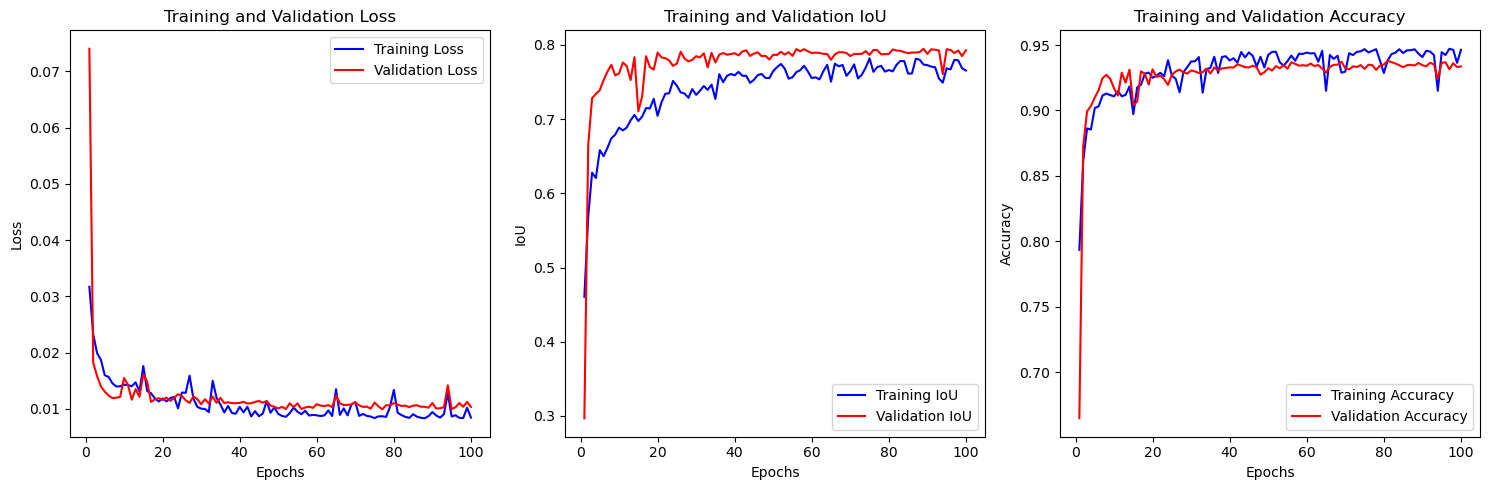

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10540\116601381.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Results:
Accuracy: 0.9107
IoU: 0.5970
Precision: 0.8756
Recall: 0.8539
F1 Score: 0.8646


In [158]:
# Plot metrics
plot_metrics(train_losses, val_losses, train_ious, val_ious, train_accuracies, val_accuracies)

# Evaluate on test set
model.load_state_dict(torch.load('best_model.pth'))
test_accuracy, test_iou, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, device)

print(f"Test Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"IoU: {test_iou:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

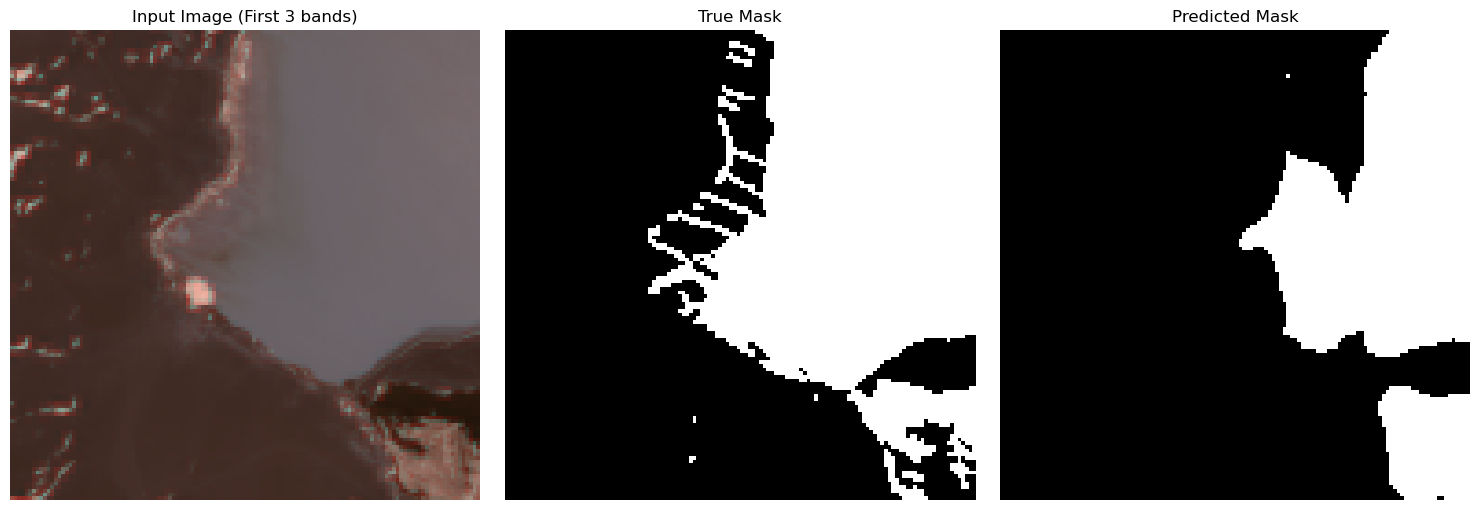

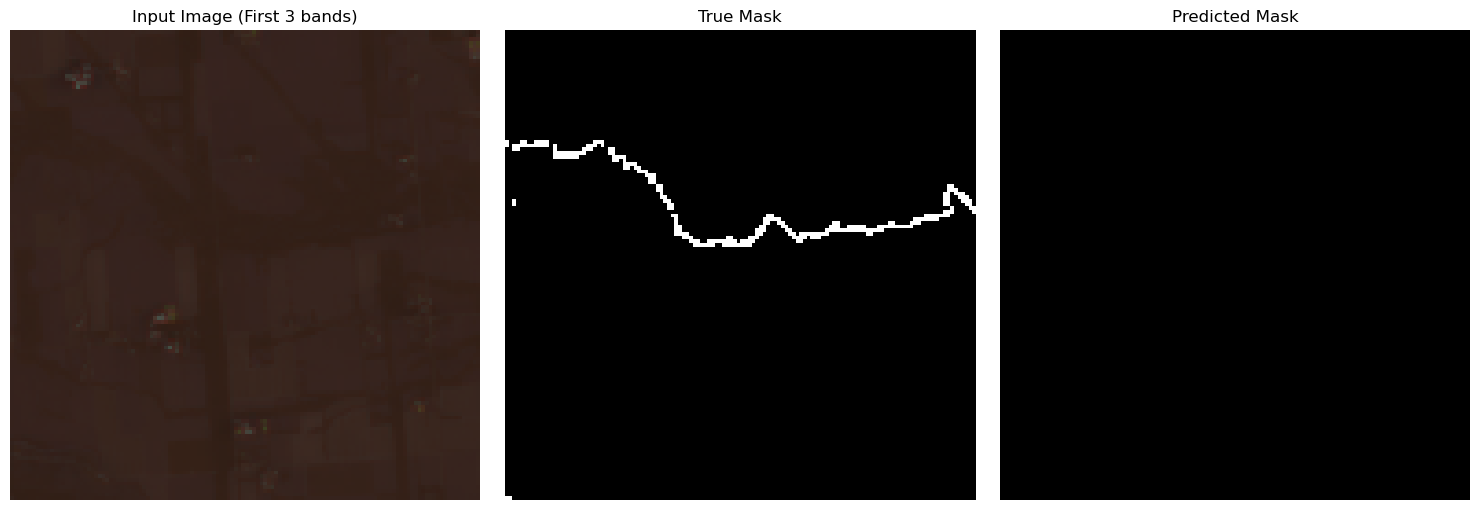

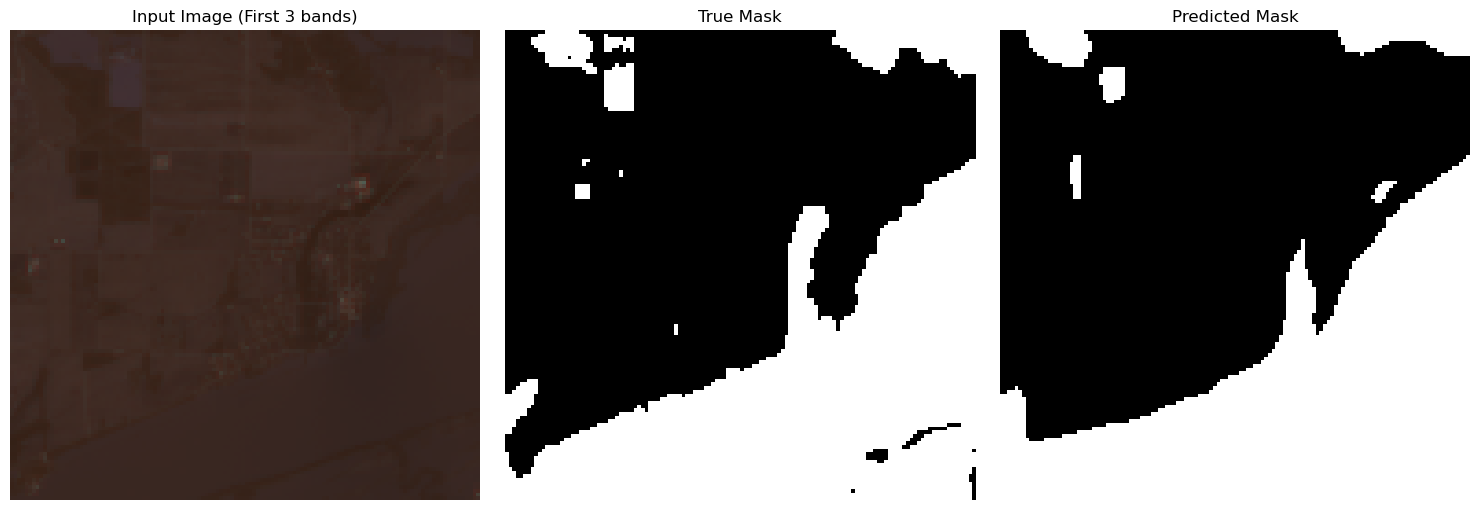

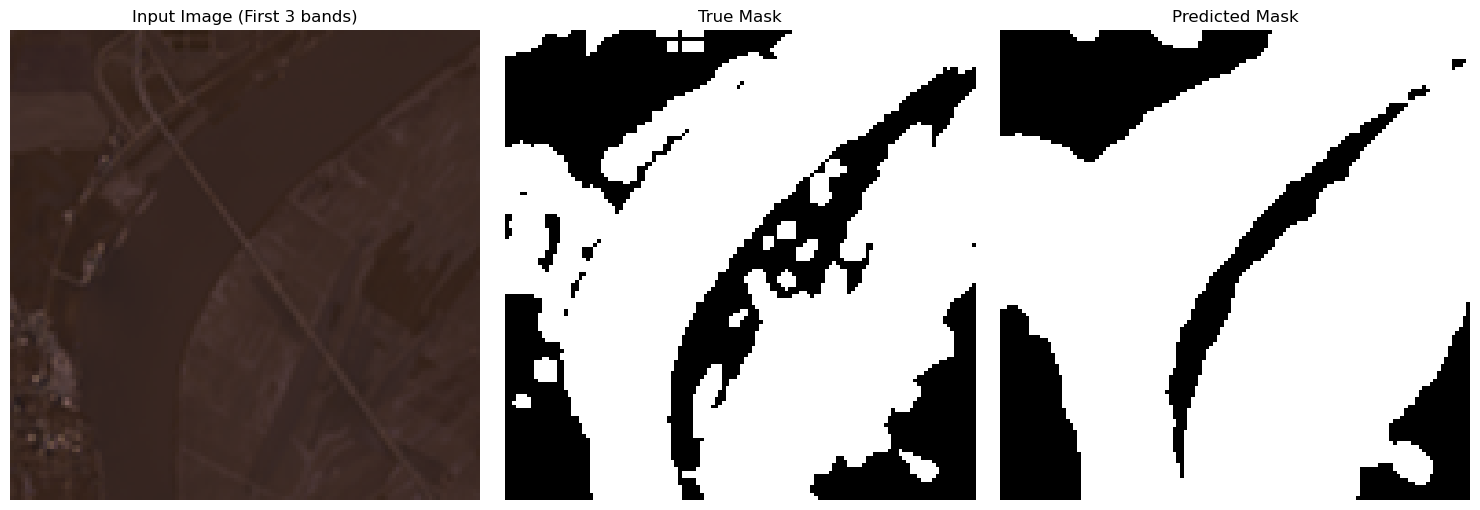

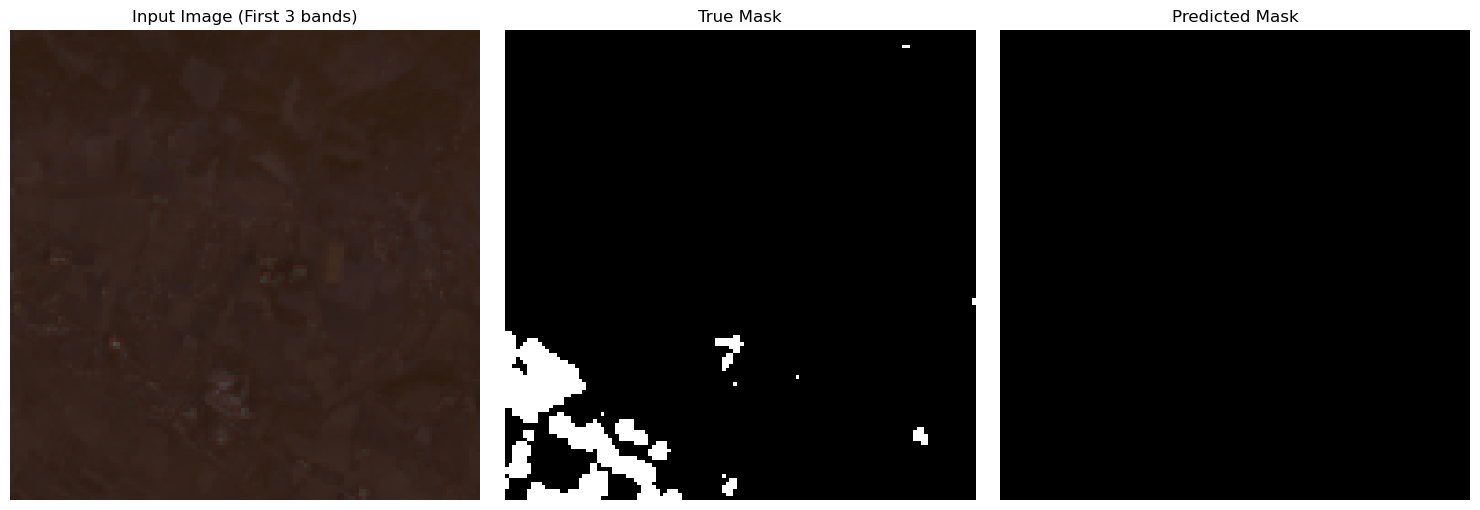

In [159]:
visualize_predictions(model, test_dataset)